In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [92]:
engage = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [98]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Identify "Adopted User"

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period.

In [30]:
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'], format='%Y%m%d').dt.normalize()

In [31]:
engage.sort_values(by=['time_stamp'], ascending=True, inplace=True)

In [62]:
date = pd.DataFrame()
date['start'] = engage['time_stamp']
date['end'] = engage['time_stamp'] + timedelta(days=6)

In [63]:
date.drop_duplicates(inplace=True)

In [83]:
uid = []
for i in range(len(date)):
    mask = (engage['time_stamp'] >= date['start'].iloc[i]) & (engage['time_stamp'] <= date['end'].iloc[i])
    temp = engage.loc[mask]
    temp = temp.groupby(['user_id']).size().reset_index()
    uid.extend(list(temp['user_id'].loc[temp[0]>2]))

In [85]:
uid = list(set(uid))

In [97]:
print("Out of a total of", len(engage.user_id.unique()), 'users,',  "{:.0%}".format(len(uid) / len(engage.user_id.unique())), 
      "of them are adopted users.")

Out of a total of 8823 users, 18% of them are adopted users.


#### Create the response variable "adopted"

Now create a dummy variable 'adopted' in the users dataset indicating whether or not the user is an adopted user. This will be the response variable in our model.

In [102]:
users['adopted'] = users['object_id'].isin(uid)

# Feature Engineering

## Extract Email

In [111]:
users['email'] = users['email'].apply(lambda x: x.split("@",1)[1])

In [117]:
users.groupby(['email']).size().reset_index().sort_values(by=[0], ascending=False).iloc[0:10, ]

,email,0
293,gmail.com,3562
1112,yahoo.com,2447
440,jourrapide.com,1259
130,cuvox.de,1202
306,gustr.com,1179
339,hotmail.com,1165
571,mumdc.com,2
725,qgjbc.com,2
531,luque.com,2
772,rerwl.com,2


The majority of users use gmail, yahoo, jourrapide, cuvox, gustr and hotmail. Regroup the rest of emails as 'other'. 

In [128]:
users['email'] = users['email'].apply(lambda x: x if x in ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com'] 
                                      else 'other')

In [129]:
users['email'].unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', 'hotmail.com',
       'cuvox.de', 'gmail.com', 'other'], dtype=object)

## Invite Dummies

In [149]:
users.rename(columns = {'object_id':'user_id'}, inplace=True)

In [134]:
users['invited_by_adopted'] = users['invited_by_user_id'].isin(uid)

In [181]:
users['invite_others'] = users['user_id'].isin(users['invited_by_user_id'])

## Extract Creation Time Dummies

In [140]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [142]:
users['creation_year'] = users['creation_time'].dt.year
users['creation_month'] = users['creation_time'].dt.month

## Number of Visits

Question: should it be included as a feature? It shouldn't be, right?

In [145]:
temp = engage.groupby(['user_id'])['visited'].sum().reset_index()

In [150]:
users = pd.merge(users, temp, how='left', on=['user_id'])

## Deal with NAs

In [152]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan

user_id                        0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
adopted                        0.000
invited_by_adopted             0.000
invite_others                  0.000
creation_year                  0.000
creation_month                 0.000
visited                       26.475
dtype: float64

46% of the users were not invited by other users to register, which is perfectly reasonable. No need to pay attention to NAs in 'invited_by_user_id', we've already created two dummies to make use of this information.

In [155]:
sum(users.last_session_creation_time.isnull() == users.visited.isnull())

12000

NAs in visited are exactly the same as those in last-session_creation_time. So we only need to deal with 'visited'. 26.475% of the users have never used the product since registration, aka, their number of visits = 0. For 'visited', fill NA with 0.

In [156]:
users['visited'] = users['visited'].fillna(value=0)

In [193]:
users['ever_visited'] = users.last_session_creation_time.isnull()

## Convert Categorical Variabels to Dummies

In [157]:
users = pd.get_dummies(users, columns=["email", 'creation_source'], 
                         prefix=["email", "source"])

## Prepare Feature Set and Target Variable

In [159]:
users.columns.values

array(['user_id', 'creation_time', 'name', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'invited_by_adopted',
       'invite_others', 'creation_year', 'creation_month', 'visited',
       'email_cuvox.de', 'email_gmail.com', 'email_gustr.com',
       'email_hotmail.com', 'email_jourrapide.com', 'email_other',
       'email_yahoo.com', 'source_GUEST_INVITE', 'source_ORG_INVITE',
       'source_PERSONAL_PROJECTS', 'source_SIGNUP',
       'source_SIGNUP_GOOGLE_AUTH'], dtype=object)

In [194]:
features = users.drop(['user_id', 'creation_time', 'name', 'last_session_creation_time', 'org_id', 'invited_by_user_id', 'adopted', 'visited'], axis=1)

In [195]:
target = users['adopted']

# Fit Model

In [162]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [196]:
rf = RandomForestClassifier(max_depth=20, n_estimators = 20, n_jobs=-1)

In [197]:
rf.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [198]:
feature_importance = pd.DataFrame(rf.feature_importances_,index = features.columns,columns=['importance'])

In [199]:
imp=feature_importance.reset_index()

In [200]:
imp.columns=['names','importance']

In [201]:
def f(row):
    if 'email' in row['names']:
        row['names']='email'
    if 'source' in row['names']:
        row['names']='creation_source'
    return row

In [202]:
imp=imp.apply(f,axis=1).groupby('names').sum()

In [203]:
imp = imp.sort_values('importance', ascending=False).reset_index()

Text(0.5,1,'Random Forest: Feature Importance')

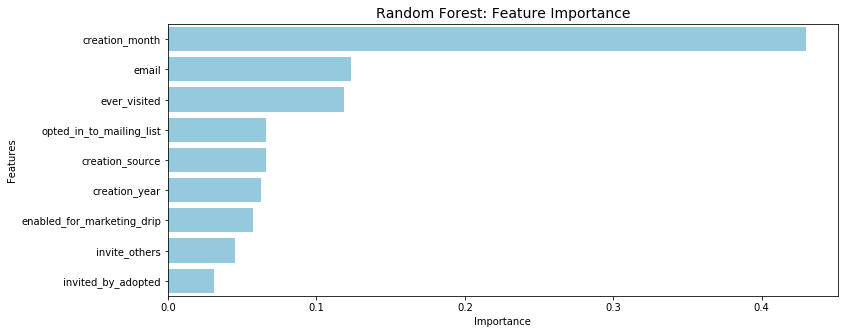

In [204]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="importance", y="names", data=imp, color= "skyblue")
plt.setp(ax.patches, linewidth=0)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest: Feature Importance', fontsize='14')
#fig.savefig('rf importance.png')